In [1]:
import os
import torch
import numpy as np

from model.HarsanyiNet import HarsanyiNet
from utils.attribute import HarsanyiNetAttribute

from utils.data import get_data_loader
from utils.plot import plot_shapley

In [2]:
train_loader, test_loader, num_classes = get_data_loader('MNIST', 50)
device = 'cuda:0' if torch.cuda.is_available() else 'cpu'

In [3]:
num_layers = 4     
channels = 32      
beta = 100         
gamma = 0.05       
num_classes = 10
in_channels = 1

path_dir = f"layers{num_layers}_channels{channels}_beta{beta}_gamma{gamma}"
model_path = os.path.join('./pretrained_model/MNIST', path_dir, 'model_pths/MNIST.pth')

In [4]:
model = HarsanyiNet(num_layers=num_layers, channel_extend=channels,
                    beta=beta, gamma=gamma,
                    num_classes=num_classes, device=device, in_channels=in_channels).to(device)

model.load_state_dict(torch.load(model_path, map_location=device))
model = model.to(device)

In [5]:
# verify the classification performance
test_correct_value = 0
test_total_num = 0

for i, (x_te, y_te) in enumerate(test_loader):
    x_te = x_te.to(device)
    y_te = y_te.to(device)

    with torch.no_grad():
        y_pred = model(x_te)
        test_correct_value += (y_pred.max(1)[1] == y_te).sum().item()
        test_total_num += x_te.size(0)

avg_te_acc = test_correct_value / test_total_num
print(f"test_acc: {avg_te_acc:.4f}\n")

test_acc: 0.9879



In [6]:
# get z0
index = 0
batch = 0

for i, (x_te, y_te) in enumerate(test_loader):
    x_te = x_te.to(device)
    y_te = y_te.to(device)
    if i == batch:
        x_te = x_te[index].unsqueeze(0)
        label = int(y_te[index])
        break

model = model.double()  # double float to ensure accurate attribution
x_te = x_te.double()
z0 = model._get_z0(x_te).double()

In [7]:
def HarsanyiNetShapley(model, x_te, label):
    calculator = HarsanyiNetAttribute(model=model, device=device)
    harsanyi = calculator.attribute(model=model, image=x_te, target_label=label)
    Harsanyi_Shapley = calculator.get_shapley(harsanyi=harsanyi)

    return Harsanyi_Shapley

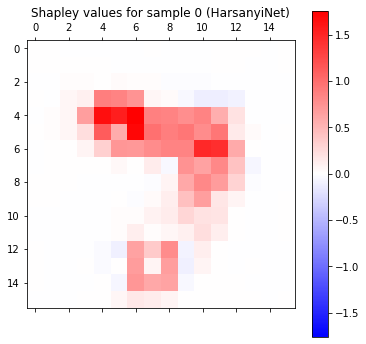

In [8]:
# compute the Shapley values using HarsanyiNet
Harsanyi_Shap = HarsanyiNetShapley(model, z0, label)

path = os.path.join('./pretrained_model/MNIST', path_dir, str(index))
plot_shapley(Harsanyi_Shap, path=path, str=f'{index} (HarsanyiNet)')

In [9]:
def SamplingShapley(model, x_te, label, runs=200):
    shapley = shapley_sampling(model=model, image=x_te, target_label=label, device=device, runs=runs)
    Sampling_Shapley = shapley.reshape(x_te.shape[-1], x_te.shape[-1])

    return Sampling_Shapley

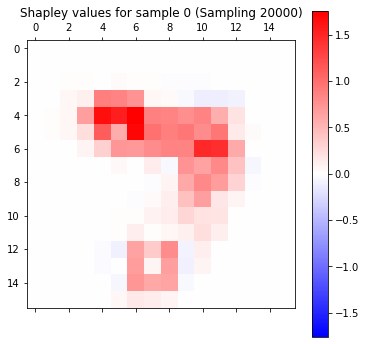

In [10]:
# compute the Shapley values using the sampling method
# the larger the number of iterations (runs) of the sampling method, the more accurate the sampling method is
from utils.image.shapley_sampling import shapley_sampling
runs = 20000
Sampling_Shap = SamplingShapley(model, z0, label, runs=runs)  

path = os.path.join('./pretrained_model/MNIST', path_dir, str(index)+'sampling')
np.save(path + '.npy', Sampling_Shap)
vmax = max(Harsanyi_Shap.max(), -Harsanyi_Shap.min())
plot_shapley(Harsanyi_Shap, path=path, str=f'{index} (Sampling {runs})', vmax=vmax)

In [11]:
def get_RMSE(method1, method2, str):
    gt = method1.reshape(-1)
    value = method2.reshape(-1)
    dim = gt.shape[0]
    loss_abs = np.abs(value - gt)
    RMSE = np.sqrt((loss_abs**2).sum() / dim)
    print(f"RMSE of {str}: {RMSE.item()}")
    return RMSE

get_RMSE(Harsanyi_Shap, Sampling_Shap, f"HarsanyiNet (1) and Sampling method ({runs})")

RMSE of HarsanyiNet (1) and Sampling method (20000): 0.00508044035878322


0.00508044035878322